In [3]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error


def manual_openfe_features(df_raw):
    df = df_raw.copy()
    freq_shell = df["Shell weight"].value_counts(normalize=True)
    freq_whole = df["Whole weight"].value_counts(normalize=True)
    freq_feature_shell = df["Shell weight"].map(freq_shell)
    freq_feature_whole = df["Whole weight"].map(freq_whole)
    
    df_manual = pd.DataFrame({
        "f01_Length_div_ShellWeight": df["Length"] / (df["Shell weight"]),
        "f02_Whole1_div_ShellWeight": df["Whole weight.1"] / (df["Shell weight"]),
        "f03_Diameter_div_ShellWeight": df["Diameter"] / (df["Shell weight"]),
        "f05_Length_minus_Shell": df["Length"] - df["Shell weight"],
        "f07_freq_ShellWeight": freq_feature_shell,
        "f08_Max_Whole2_Shell": df[["Whole weight.2", "Shell weight"]].max(axis=1),
        "f09_log_Whole_weight": np.log(df["Whole weight"]),
        "f10_freq_WholeWeight": freq_feature_whole,
        "f11_Shell_plus_Height": df["Shell weight"] + df["Height"],
    })
    return df_manual



df = pd.read_csv("train_cleaned_sex_binary.csv")  
y = df["Rings"]
X_raw = df.drop(columns=["Rings", "id"], errors='ignore') 

X_manual = manual_openfe_features(X_raw)
X_final = pd.concat([X_raw.reset_index(drop=True), X_manual], axis=1)
X_final = X_final.drop(columns=["Length", "Whole weight"], errors="ignore")

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)



def catboost_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1.0),
        'verbose': 0,
        'random_seed': 42
    }

    model = CatBoostRegressor(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return np.mean(scores)


study = optuna.create_study(direction='maximize')
study.optimize(catboost_objective, n_trials=100)

best_params = study.best_trial.params
print("Best Parameters:", best_params)
print("Best CV MSE:", -study.best_value)


best_model = CatBoostRegressor(**best_params)
best_model.fit(X_train, y_train, verbose=0)

y_pred = best_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_pred)
print("Final Test MSE:", final_mse)


[I 2025-05-26 19:15:46,781] A new study created in memory with name: no-name-7af1e510-814c-4c41-ac5e-5c3876e3953f
[I 2025-05-26 19:15:54,051] Trial 0 finished with value: -3.2667762141747625 and parameters: {'iterations': 371, 'learning_rate': 0.13453097577251374, 'depth': 7, 'l2_leaf_reg': 9.717836042506406, 'random_strength': 0.27798191481746176, 'bagging_temperature': 0.018544760375579394}. Best is trial 0 with value: -3.2667762141747625.
[I 2025-05-26 19:15:59,494] Trial 1 finished with value: -3.2729906027853524 and parameters: {'iterations': 388, 'learning_rate': 0.11582677578268655, 'depth': 5, 'l2_leaf_reg': 4.800573247737096, 'random_strength': 0.46347369100075303, 'bagging_temperature': 0.7294497763652563}. Best is trial 0 with value: -3.2667762141747625.
[I 2025-05-26 19:16:07,030] Trial 2 finished with value: -3.306594532301161 and parameters: {'iterations': 296, 'learning_rate': 0.2056879779574786, 'depth': 8, 'l2_leaf_reg': 2.2448265350688277, 'random_strength': 9.4800323

Best Parameters: {'iterations': 498, 'learning_rate': 0.10761673949682667, 'depth': 7, 'l2_leaf_reg': 8.232303507631775, 'random_strength': 0.5454882612651083, 'bagging_temperature': 0.9923308656690859}
Best CV MSE: 3.2561719106269953
Final Test MSE: 3.3030338696682997


Train MSE: 2.7745, R²: 0.7061, RMSLE: 0.1391
Test MSE:  3.3096, R²: 0.6521, RMSLE: 0.1471


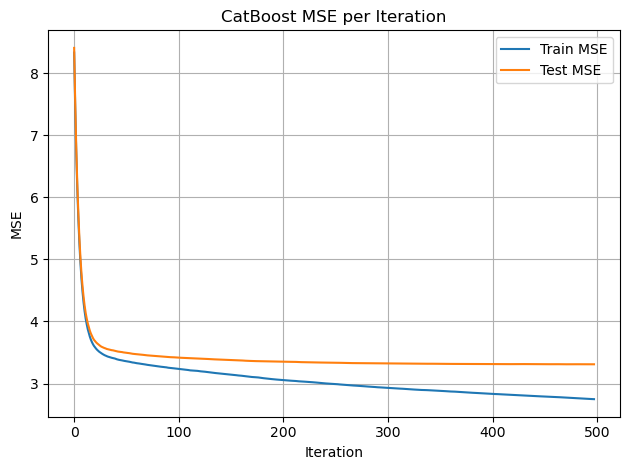

In [9]:
from catboost import CatBoostRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from math import sqrt


best_params = {
    'iterations': 498,
    'learning_rate': 0.10761673949682667,
    'depth': 7,
    'l2_leaf_reg': 8.232303507631775,
    'random_strength': 0.5454882612651083,
    'bagging_temperature': 0.9923308656690859,
    'verbose': False,
    'random_seed': 42
}


model = CatBoostRegressor(**best_params)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)


eval_result = model.get_evals_result()
train_rmse = eval_result['learn']['RMSE']
test_rmse = eval_result['validation']['RMSE']
train_mse = np.square(train_rmse)
test_mse = np.square(test_rmse)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_mse_final = mean_squared_error(y_train, y_train_pred)
test_mse_final = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmsle = sqrt(mean_squared_log_error(y_train, np.maximum(0, y_train_pred)))
test_rmsle = sqrt(mean_squared_log_error(y_test, np.maximum(0, y_test_pred)))

print(f"Train MSE: {train_mse_final:.4f}, R²: {train_r2:.4f}, RMSLE: {train_rmsle:.4f}")
print(f"Test MSE:  {test_mse_final:.4f}, R²: {test_r2:.4f}, RMSLE: {test_rmsle:.4f}")


plt.plot(train_mse, label='Train MSE')
plt.plot(test_mse, label='Test MSE')
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("CatBoost MSE per Iteration")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("catboost_mse_plot.png", dpi=300)
plt.show()

